# Dementia Prediction
- **Dementia** is one of the common causes of memory loss and death gloabally. Many people are not even aware of the fact that they might have dementia or not. Hence, we are driven by this motivation to build machine learning applications that have no unbiasedness and possess high probability of detecting and predicting dementia at any stage.

#### Introduction 
> This project leverages deep learning models(CNN models) for the prediction of Dementia or no Dementia amongst well represented patients samples. 
> This project will make use of pytorch and different CNN models. 
- The best model will be deployed for real usage in medical sectors for dementia prediction 

#### Importing Libraries 

In [1]:
#import methods from the torchvision class
import torch
from sklearn.metrics import accuracy_score
from torchmetrics import Precision, Recall, F1Score
from torchvision.datasets import ImageFolder 
from torchvision import transforms , datasets , models
from torch.utils.data import DataLoader, random_split 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt 
import os 
import torch.nn as nn 

from __future__ import print_function, division
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import copy
import time 

plt.ion()   # This is the interactive mode


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
print(os.path.exists('Alzheimer_dataset/train'))

True


In [3]:
print(os.listdir('Alzheimer_dataset/train'))

['Dementia', 'NonDementia']


### Prior Examination and transformation 
#### Transformation 

In [4]:

#use the transforms object to apply the needed transformation by accessing the Compose class 
#using the transforms object
transform_traindata = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(128, 128)),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((128, 128))
])


#use only the three transform methods
transform_testdata= transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     transforms.Resize((128, 128))
])

#### Data Collection 

In [5]:
train_data = ImageFolder(
    #use the "r" to make python avoid escape issues
  r"C:\Users\512GB\OneDrive\Documents\Research Projects\Dementia Research\Deep-Learning-and-Classical-ML-models-for-Dementia-Prediction\Predicting Dementia\Alzheimer_dataset\train",
  transform = transform_traindata
)

train_size= int(0.8 * len(train_data))
val_size= len(train_data) - train_size

train_dataset, val_dataset= random_split(train_data, [train_size, val_size])

val_dataset.transform= transform_testdata



test = ImageFolder(
    #use the "r" to make python avoid escape issues
  r"C:\Users\512GB\OneDrive\Documents\Research Projects\Dementia Research\Deep-Learning-and-Classical-ML-models-for-Dementia-Prediction\Predicting Dementia\Alzheimer_dataset\test",
  transform = transform_testdata
)   


In [6]:
#instantiate an object of the data loader class 
dataloader_train = DataLoader(
  train_dataset, shuffle=True, batch_size=20, num_workers=2
)

dataloader_val = DataLoader(
    val_dataset, shuffle= False, batch_size=10, num_workers=2
     
)

dataloader_test= DataLoader(
    test, shuffle=False, batch_size=10, num_workers=2
) 

In [7]:
print(len(dataloader_train))
print(len(dataloader_test))
print(len(dataloader_val))

203
110
102


In [8]:
#get an image and its label
image, label = next(iter(dataloader_train))
#Reshape the image tensor
print(image.shape ) 


torch.Size([20, 3, 128, 128])


In [9]:
#image = image.squeeze().permute(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

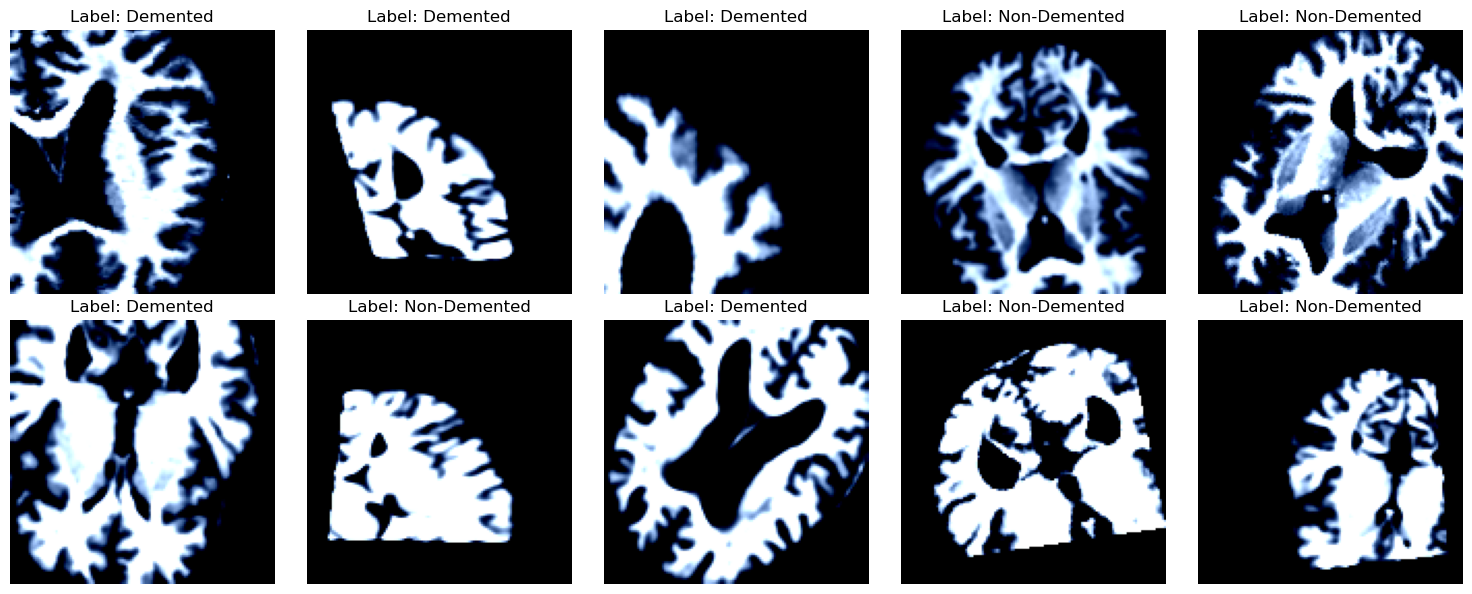

In [10]:
import matplotlib.pyplot as plt

# Define the figure (2 rows with 5 images each) and axis objects
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# Flatten the axes array
axs = axs.ravel()

# Initialize index for subplots
subplot_index = 0

# Load first 10 examples
for images, labels in dataloader_train:
    if subplot_index >= 10:  # Only plot up to 10 images
        break

    # Plot individual images from the batch
    for j in range(images.size(0)):  # Loop through the batch
        if subplot_index >= 10:  # Stop if we have plotted 10 images
            break
        
        # Extract the j-th image and label from the batch
        image = images[j]  # shape [3, 128, 128]
        label = labels[j]  # Assuming labels is of the same size as images

        # Plot image and set title to the corresponding label
        axs[subplot_index].imshow(image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
        axs[subplot_index].title.set_text(f'Label: {"Demented" if label.item() == 0 else "Non-Demented"}')
        axs[subplot_index].axis('off')  # Hide axes for visual appeal

        subplot_index += 1  # Move to the next subplot

plt.tight_layout()
plt.show();


#### Feature Extraction and fully connected layers

In [11]:
#create a class of the model on the nn.Module parent class

class Net(nn.Module):
    """
    Define the arguments and parameters hers 
    Define the arguments and parameters hers
    Define the arguments and parameters hers
    Define the arguments and parameters hers
    Define the arguments and parameters hers
    """
    #initialize the class constructor and input self and needed parameters
    def __init__(self, num_classes):
        #connec the class with the properties and methods using the super function
        super().__init__()
        #define the sequential method to extract the needed features
        self.feature_extractor= nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),


            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),


            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),


            nn.Flatten() 

        )

        self.imageclassifier = nn.Sequential( 
            nn.Linear(128 * 16 * 16 , 256),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        


    def forward(self, x):
            x= self.feature_extractor(x)
            x= self.imageclassifier(x)
            return x 


In [12]:
model_inspection = Net(num_classes=2)
print(model_inspection)

Net(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (imageclassifier): Sequential(
    (0): Line

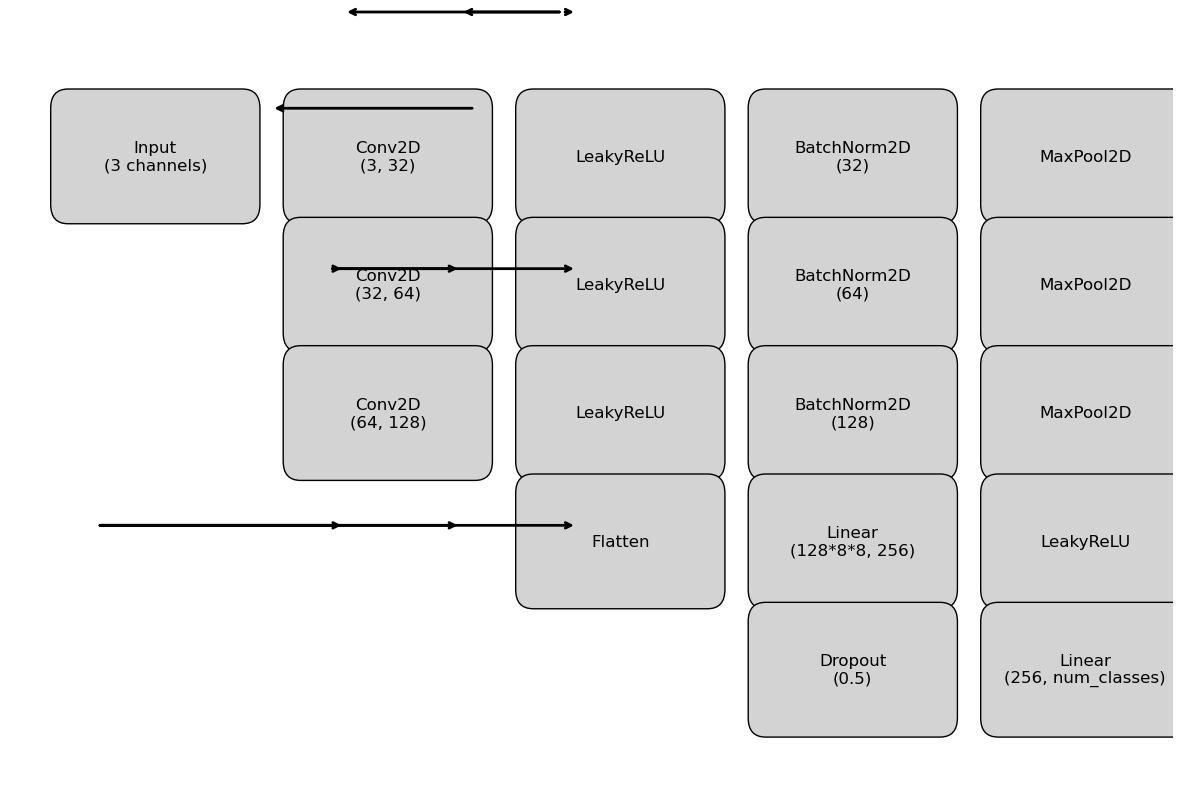

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to draw a rectangle with text
def draw_rectangle(ax, xy, width, height, text, fontsize=10):
    rect = patches.FancyBboxPatch(xy, width, height, boxstyle="round,pad=0.3", 
                                  edgecolor="black", facecolor="lightgray")
    ax.add_patch(rect)
    ax.text(xy[0] + width / 2, xy[1] + height / 2, text, ha="center", va="center", 
            fontsize=fontsize, color="black")

# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_xlim(0, 20)
ax.set_ylim(0, 12)
ax.axis('off')  # Turn off the axes

# Draw the rectangles for each layer with more spacing and larger font
layer_width = 3
layer_height = 1.5

draw_rectangle(ax, (1, 9), layer_width, layer_height, "Input\n(3 channels)", fontsize=12)
draw_rectangle(ax, (5, 9), layer_width, layer_height, "Conv2D\n(3, 32)", fontsize=12)
draw_rectangle(ax, (9, 9), layer_width, layer_height, "LeakyReLU", fontsize=12)
draw_rectangle(ax, (13, 9), layer_width, layer_height, "BatchNorm2D\n(32)", fontsize=12)
draw_rectangle(ax, (17, 9), layer_width, layer_height, "MaxPool2D", fontsize=12)

draw_rectangle(ax, (5, 7), layer_width, layer_height, "Conv2D\n(32, 64)", fontsize=12)
draw_rectangle(ax, (9, 7), layer_width, layer_height, "LeakyReLU", fontsize=12)
draw_rectangle(ax, (13, 7), layer_width, layer_height, "BatchNorm2D\n(64)", fontsize=12)
draw_rectangle(ax, (17, 7), layer_width, layer_height, "MaxPool2D", fontsize=12)

draw_rectangle(ax, (5, 5), layer_width, layer_height, "Conv2D\n(64, 128)", fontsize=12)
draw_rectangle(ax, (9, 5), layer_width, layer_height, "LeakyReLU", fontsize=12)
draw_rectangle(ax, (13, 5), layer_width, layer_height, "BatchNorm2D\n(128)", fontsize=12)
draw_rectangle(ax, (17, 5), layer_width, layer_height, "MaxPool2D", fontsize=12)

draw_rectangle(ax, (9, 3), layer_width, layer_height, "Flatten", fontsize=12)
draw_rectangle(ax, (13, 3), layer_width, layer_height, "Linear\n(128*8*8, 256)", fontsize=12)
draw_rectangle(ax, (17, 3), layer_width, layer_height, "LeakyReLU", fontsize=12)
draw_rectangle(ax, (13, 1), layer_width, layer_height, "Dropout\n(0.5)", fontsize=12)
draw_rectangle(ax, (17, 1), layer_width, layer_height, "Linear\n(256, num_classes)", fontsize=12)

# Draw arrows between layers
arrow_props = dict(arrowstyle="->", linewidth=2, color="black")

for start, end in [(4, 9.75), (8, 9.75), (12, 9.75), (16, 9.75),
                   (4, 7.75), (8, 7.75), (12, 7.75), (16, 7.75),
                   (4, 5.75), (8, 5.75), (12, 5.75), (16, 5.75),
                   (10.5, 4.5), (14.5, 4.5), (14.5, 2.5), (14.5, 2)]:
    ax.annotate("", xy=(end, start), xytext=(start-2.5, start),
                arrowprops=arrow_props)

# Display the plot
plt.show()


#### Training Loop 

In [14]:
import torch
import torch.optim as optim 

# Initialize the Net class
net = Net(num_classes=2)

# Initialize the CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer1 = optim.Adam(net.parameters(), lr=0.0005)

# Number of epochs
num_epochs = 50

# Lists to store the loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs): 
    net.train()  # Set the model to training mode
    running_loss = 0
    
    # Training loop
    for images, labels in dataloader_train:
        optimizer1.zero_grad()  # Zero the gradients
        outputs = net(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer1.step()  # Update weights
        
        running_loss += loss.item()  # Accumulate loss
    
    epoch_loss = running_loss / len(dataloader_train)
    train_losses.append(epoch_loss)  # Store training loss
    
    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_running_loss = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader_val:
            outputs = net(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            val_running_loss += loss.item()  # Accumulate validation loss
    
    val_loss = val_running_loss / len(dataloader_val)
    val_losses.append(val_loss)  # Store validation loss
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")



Epoch 1/50, Train Loss: 1.0093, Val Loss: 0.6729
Epoch 2/50, Train Loss: 0.6852, Val Loss: 0.6378
Epoch 3/50, Train Loss: 0.6734, Val Loss: 0.6488
Epoch 4/50, Train Loss: 0.6694, Val Loss: 0.6329
Epoch 5/50, Train Loss: 0.6498, Val Loss: 0.6278
Epoch 6/50, Train Loss: 0.6591, Val Loss: 0.6376
Epoch 7/50, Train Loss: 0.6645, Val Loss: 0.6232
Epoch 8/50, Train Loss: 0.6437, Val Loss: 0.6031
Epoch 9/50, Train Loss: 0.6442, Val Loss: 0.6367
Epoch 10/50, Train Loss: 0.6490, Val Loss: 0.6230
Epoch 11/50, Train Loss: 0.6412, Val Loss: 0.6156
Epoch 12/50, Train Loss: 0.6425, Val Loss: 0.6093
Epoch 13/50, Train Loss: 0.6313, Val Loss: 0.5973
Epoch 14/50, Train Loss: 0.6319, Val Loss: 0.5995
Epoch 15/50, Train Loss: 0.6345, Val Loss: 0.6048
Epoch 16/50, Train Loss: 0.6427, Val Loss: 0.6219
Epoch 17/50, Train Loss: 0.6465, Val Loss: 0.5936
Epoch 18/50, Train Loss: 0.6248, Val Loss: 0.6477
Epoch 19/50, Train Loss: 0.6268, Val Loss: 0.6000
Epoch 20/50, Train Loss: 0.6314, Val Loss: 0.6171
Epoch 21/

#### Plot the train and val loss curves 

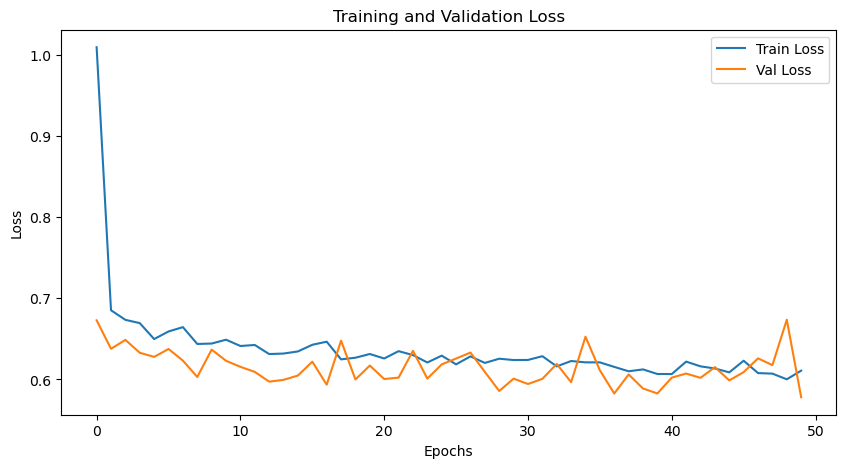

In [15]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5)) 
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.legend()
plt.show()

#### Testing Phase

In [16]:
# Test the model after training is complete
net.eval()  # Set the model to evaluation mode
test_running_loss = 0
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation
    for images, labels in dataloader_test:
        outputs = net(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        test_running_loss += loss.item()  # Accumulate test loss
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_running_loss / len(dataloader_test)
accuracy = correct / total * 100

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Test Loss: 0.6501, Test Accuracy: 62.11%


#### Evaluation Per class 

In [18]:
from sklearn.metrics import classification_report
import numpy as np 

# Ensure model is in evaluation mode
net.eval()

# Initialize lists to collect labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for sklearn
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Generate classification report
target_names = list(test.class_to_idx.keys())  # Class names
report = classification_report(all_labels, all_preds, target_names=target_names, zero_division=0)

print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

    Dementia       0.53      0.92      0.67       458
 NonDementia       0.87      0.41      0.56       640

    accuracy                           0.62      1098
   macro avg       0.70      0.66      0.61      1098
weighted avg       0.73      0.62      0.60      1098



## Using RESNET 

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Load pre-trained ResNet18 model
pretrained_model = models.resnet18(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match our number of classes 
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 2) 

##### Training loop

In [20]:
from sklearn.metrics import accuracy_score

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(pretrained_model.fc.parameters(), lr=0.0005)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)


num_epochs = 50


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def compute_accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    return accuracy_score(labels.cpu(), preds.cpu())

for epoch in range(num_epochs): 
    pretrained_model.train()  
    running_loss = 0
    all_preds = []
    all_labels = []
    
    # Training loop
    for images, labels in dataloader_train:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_resnet.zero_grad() 
        outputs = pretrained_model(images)  
        loss = criterion(outputs, labels)  
        loss.backward()  
        optimizer_resnet.step()  
        
        running_loss += loss.item() 
        
        all_preds.extend(outputs.cpu().detach().numpy())
        all_labels.extend(labels.cpu().detach().numpy())
    
    epoch_loss = running_loss / len(dataloader_train)
    train_losses.append(epoch_loss) 
    
    train_accuracy = compute_accuracy(torch.tensor(all_preds), torch.tensor(all_labels))
    train_accuracies.append(train_accuracy)  
    
    # Validation phase
    pretrained_model.eval()  # Set the model to evaluation mode
    val_running_loss = 0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader_val:
            images, labels = images.to(device), labels.to(device)
            outputs = pretrained_model(images)  
            loss = criterion(outputs, labels)  
            val_running_loss += loss.item() 
            
            all_val_preds.extend(outputs.cpu().detach().numpy())
            all_val_labels.extend(labels.cpu().detach().numpy())
    
    val_loss = val_running_loss / len(dataloader_val)
    val_losses.append(val_loss)  
    
    val_accuracy = compute_accuracy(torch.tensor(all_val_preds), torch.tensor(all_val_labels))
    val_accuracies.append(val_accuracy)  
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")



Epoch 1/50, Train Loss: 0.6672, Train Accuracy: 0.61%, Val Loss: 0.6792, Val Accuracy: 0.59%
Epoch 2/50, Train Loss: 0.6601, Train Accuracy: 0.62%, Val Loss: 0.6381, Val Accuracy: 0.64%
Epoch 3/50, Train Loss: 0.6598, Train Accuracy: 0.63%, Val Loss: 0.6426, Val Accuracy: 0.63%
Epoch 4/50, Train Loss: 0.6464, Train Accuracy: 0.63%, Val Loss: 0.6618, Val Accuracy: 0.60%
Epoch 5/50, Train Loss: 0.6637, Train Accuracy: 0.61%, Val Loss: 0.6377, Val Accuracy: 0.65%
Epoch 6/50, Train Loss: 0.6532, Train Accuracy: 0.62%, Val Loss: 0.6405, Val Accuracy: 0.65%
Epoch 7/50, Train Loss: 0.6471, Train Accuracy: 0.63%, Val Loss: 0.6497, Val Accuracy: 0.63%
Epoch 8/50, Train Loss: 0.6496, Train Accuracy: 0.63%, Val Loss: 0.6644, Val Accuracy: 0.60%
Epoch 9/50, Train Loss: 0.6495, Train Accuracy: 0.62%, Val Loss: 0.6216, Val Accuracy: 0.64%
Epoch 10/50, Train Loss: 0.6402, Train Accuracy: 0.64%, Val Loss: 0.6322, Val Accuracy: 0.62%
Epoch 11/50, Train Loss: 0.6478, Train Accuracy: 0.64%, Val Loss: 0.6

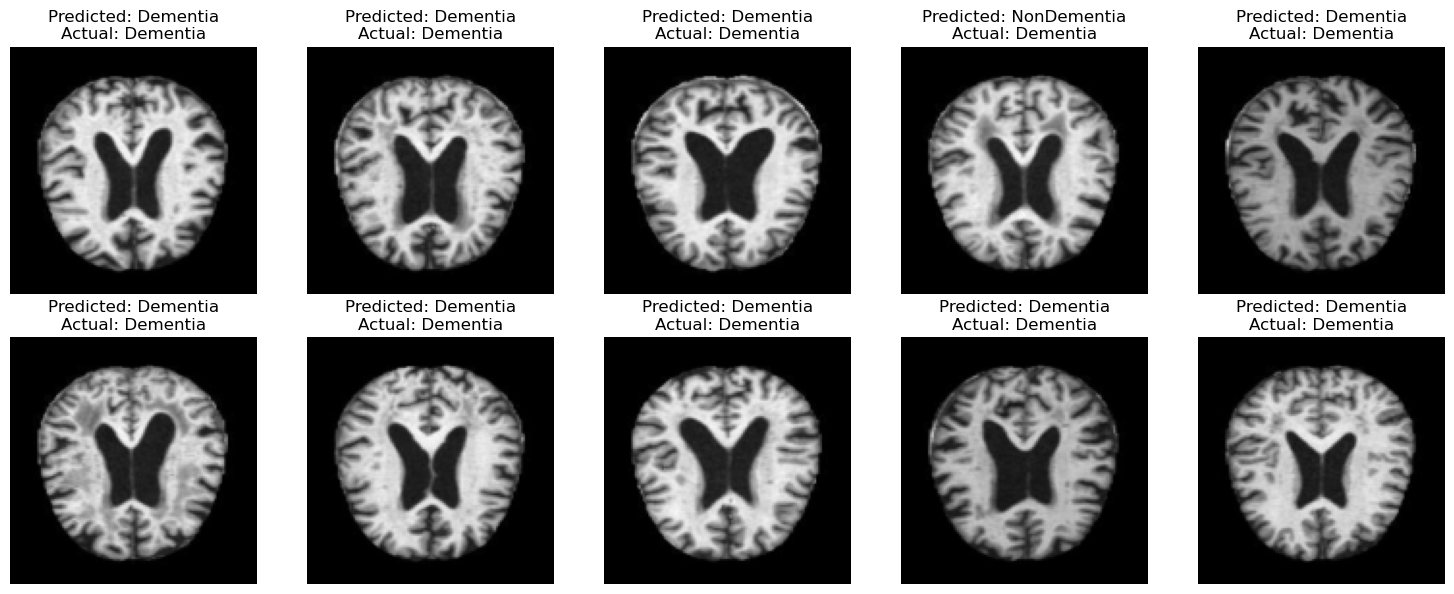

In [23]:


def imshow(image, ax=None, title=None):
    """Helper function to display an image with title on the specified axis."""
    if ax is None:
        ax = plt.gca() 
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')  # Hide axes

# Get a batch of test data
dataiter = iter(dataloader_test)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


pretrained_model.eval()
outputs = pretrained_model(images)
_, preds = torch.max(outputs, 1)


class_names = test.classes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  
for i in range(10):
    ax = axes[i // 5, i % 5]  # Select the correct subplot
    imshow(images.cpu().data[i], ax=ax, 
           title=f"Predicted: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}")

plt.tight_layout() 
plt.show()


#### Prediction Functions 

In [24]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

def plot_predictions(images, labels, preds, confidence_scores):
    plt.figure(figsize=(12, 12))
    for i in range(min(10, len(images))):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        plt.title(f"Label: {labels[i].item()}\nPred: {preds[i].item()}\nConf: {confidence_scores[i]:.2f}")
        plt.axis('off')
    plt.show()

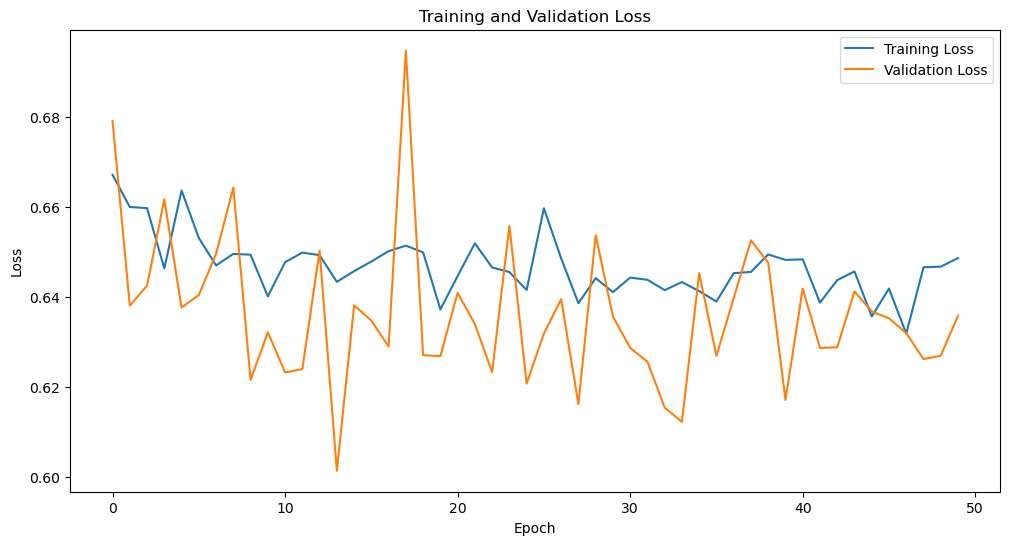

In [25]:
# Plotting loss curves
plot_loss_curves(train_losses, val_losses)

In [26]:
# Save the Resnet model 
torch.save(pretrained_model.state_dict(), "resnet_model.pth")
print("Resnet model saved!")

Resnet model saved!


In [27]:
# Load the best model for testing
pretrained_model.load_state_dict(torch.load("resnet_model.pth"))

<All keys matched successfully>

In [41]:
from sklearn.metrics import classification_report

# Testing phase
pretrained_model.eval()
test_preds = []
test_labels = []
test_images = []
confidence_scores = []

with torch.no_grad():
    for images, labels in dataloader_test:
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_model(images)  # Get logits
        
        # Compute probabilities using softmax
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
        # Extract the maximum probability for confidence scores
        max_probs, preds = torch.max(probabilities, 1)
        
        # Collect predictions, labels, and confidence scores
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        confidence_scores.extend(max_probs.cpu().numpy())
        test_images.extend(images.cpu())

# Classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=['Non-Demented', 'Demented']))



Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.54      0.72      0.62       458
    Demented       0.74      0.56      0.64       640

    accuracy                           0.63      1098
   macro avg       0.64      0.64      0.63      1098
weighted avg       0.66      0.63      0.63      1098



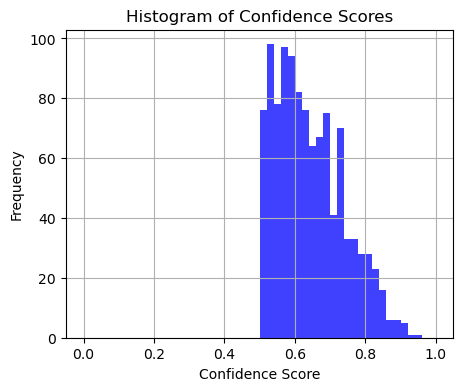

In [42]:
confidence_scores = np.array(confidence_scores)

# Histogram of confidence scores
plt.figure(figsize=(5, 4))
plt.hist(confidence_scores, bins=50, range=(0, 1), alpha=0.75, color='blue')
plt.title('Histogram of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [35]:
import seaborn as sns 
# Convert lists to numpy arrays for easier handling
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

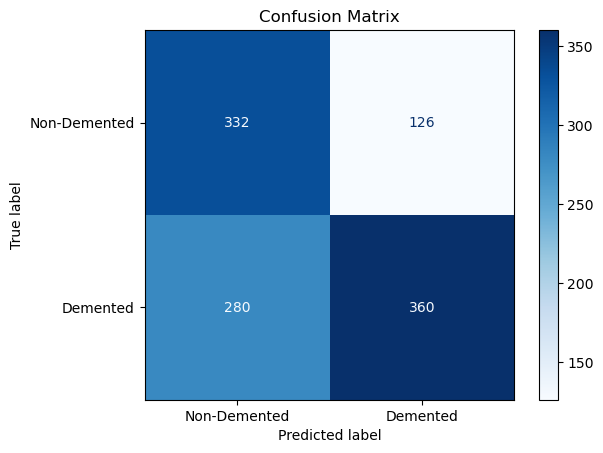

In [43]:
# Confusion matrix with confidence scores
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Demented', 'Demented'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## Using Vision Transformer 

## Using VGGNet

## Hyper Parameter Tuning With Ray Tune (For thes best model)